In [1]:
using DataFrames

import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
module InferMean
    using Base.Dates
    
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    plt.rc("figure", dpi=300.0)
    plt.rc("figure", figsize=(12,8))
    plt.rc("savefig", dpi=300.0)
    plt.rc("text", usetex=false)
    plt.rc("font", family="serif")
    plt.rc("font", serif="Palatino")
    
    data_dir = "../"
    stan_increment = Day(3)
    stan_days = Day(9)
    janfirst = Date(2015,1,1)
    include(data_dir*"/src/TempModel.jl")
    include(data_dir*"/src/infermean.jl")
    """ Convenience function to get the mean TnTx as a function
        of hour of measurement.
    """
    function get_mean_TnTx_by_hr(station_data, hours::AbstractVector{Hour})
        id = station_data[:station][1]
        meanTnTx_by_hr = Vector{Float64}(length(hours))
        for (i_hr, hr) in enumerate(hours)
            TnTx_test = TempModel.test_data(station_data, id, hr)
            meanTnTx = mean((mean(TnTx_test[:Tn]), mean(TnTx_test[:Tx])))
            meanTnTx_by_hr[i_hr] = meanTnTx
        end
        return meanTnTx_by_hr
    end
    function plot_mean_TnTx(hours, meanTnTx_by_hr, true_mean_temp)
        cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
        plt.plot(hours ./ Hour(1), meanTnTx_by_hr, linewidth=3, color=cbbPalette[1])
        plt.axhline(true_mean_temp, color=cbbPalette[3], linestyle=":", zorder=-1)
        plt.text(10.0, true_mean_temp+0.01, "true mean temp")
        plt.xlabel("Hour of Measurement (UTC)")
        plt.ylabel(L"$(\overline{\mathrm{T}_x} + \overline{\mathrm{T}_n}) / 2$")
    end
end
TempModel = InferMean.TempModel

InferMean.TempModel

In [3]:
using Base.Dates
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
data_dir = "../"
;

In [4]:
logging(DevNull; kind=:warn)
isdList=TempModel.read_isdList(; data_dir=data_dir)
logging()
head(isdList[isdList[:WBAN] .!= 99999, :])

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,37970,35047,MANSTON,UK,,EGMH,51.35,1.333,50.0,1930,2015,6.8701e6,5.47212e6
2,40180,16201,KEFLAVIK NAVAL AIR STATION,IC,,BIKF,63.967,-22.6,52.1,1942,2015,4.84443e6,5.0539e6
3,70380,34061,EVREUX,FR,,LFOE,49.017,1.217,138.0,1973,2015,7.10229e6,5.35076e6
4,71790,34051,TOUL / ROSIERES,FR,,LFSL,48.783,5.983,286.0,1973,2015,7.2702e6,5.66068e6
5,73540,34048,CHATEAURROUX DEOLS,FR,,LFLX,46.867,1.717,157.0,1936,2015,7.33498e6,5.2807e6
6,84490,13025,ROTA NAVAL AIR STATION,SP,,LERT,36.65,-6.35,25.6,1973,2015,8.01837e6,4.15324e6


In [5]:
all_csv_files = filter(x->endswith(x, ".csv"), readdir("../data2015"))
usaf_wban = [parse.(split(s, ".")[1:2]) for s in all_csv_files]
;

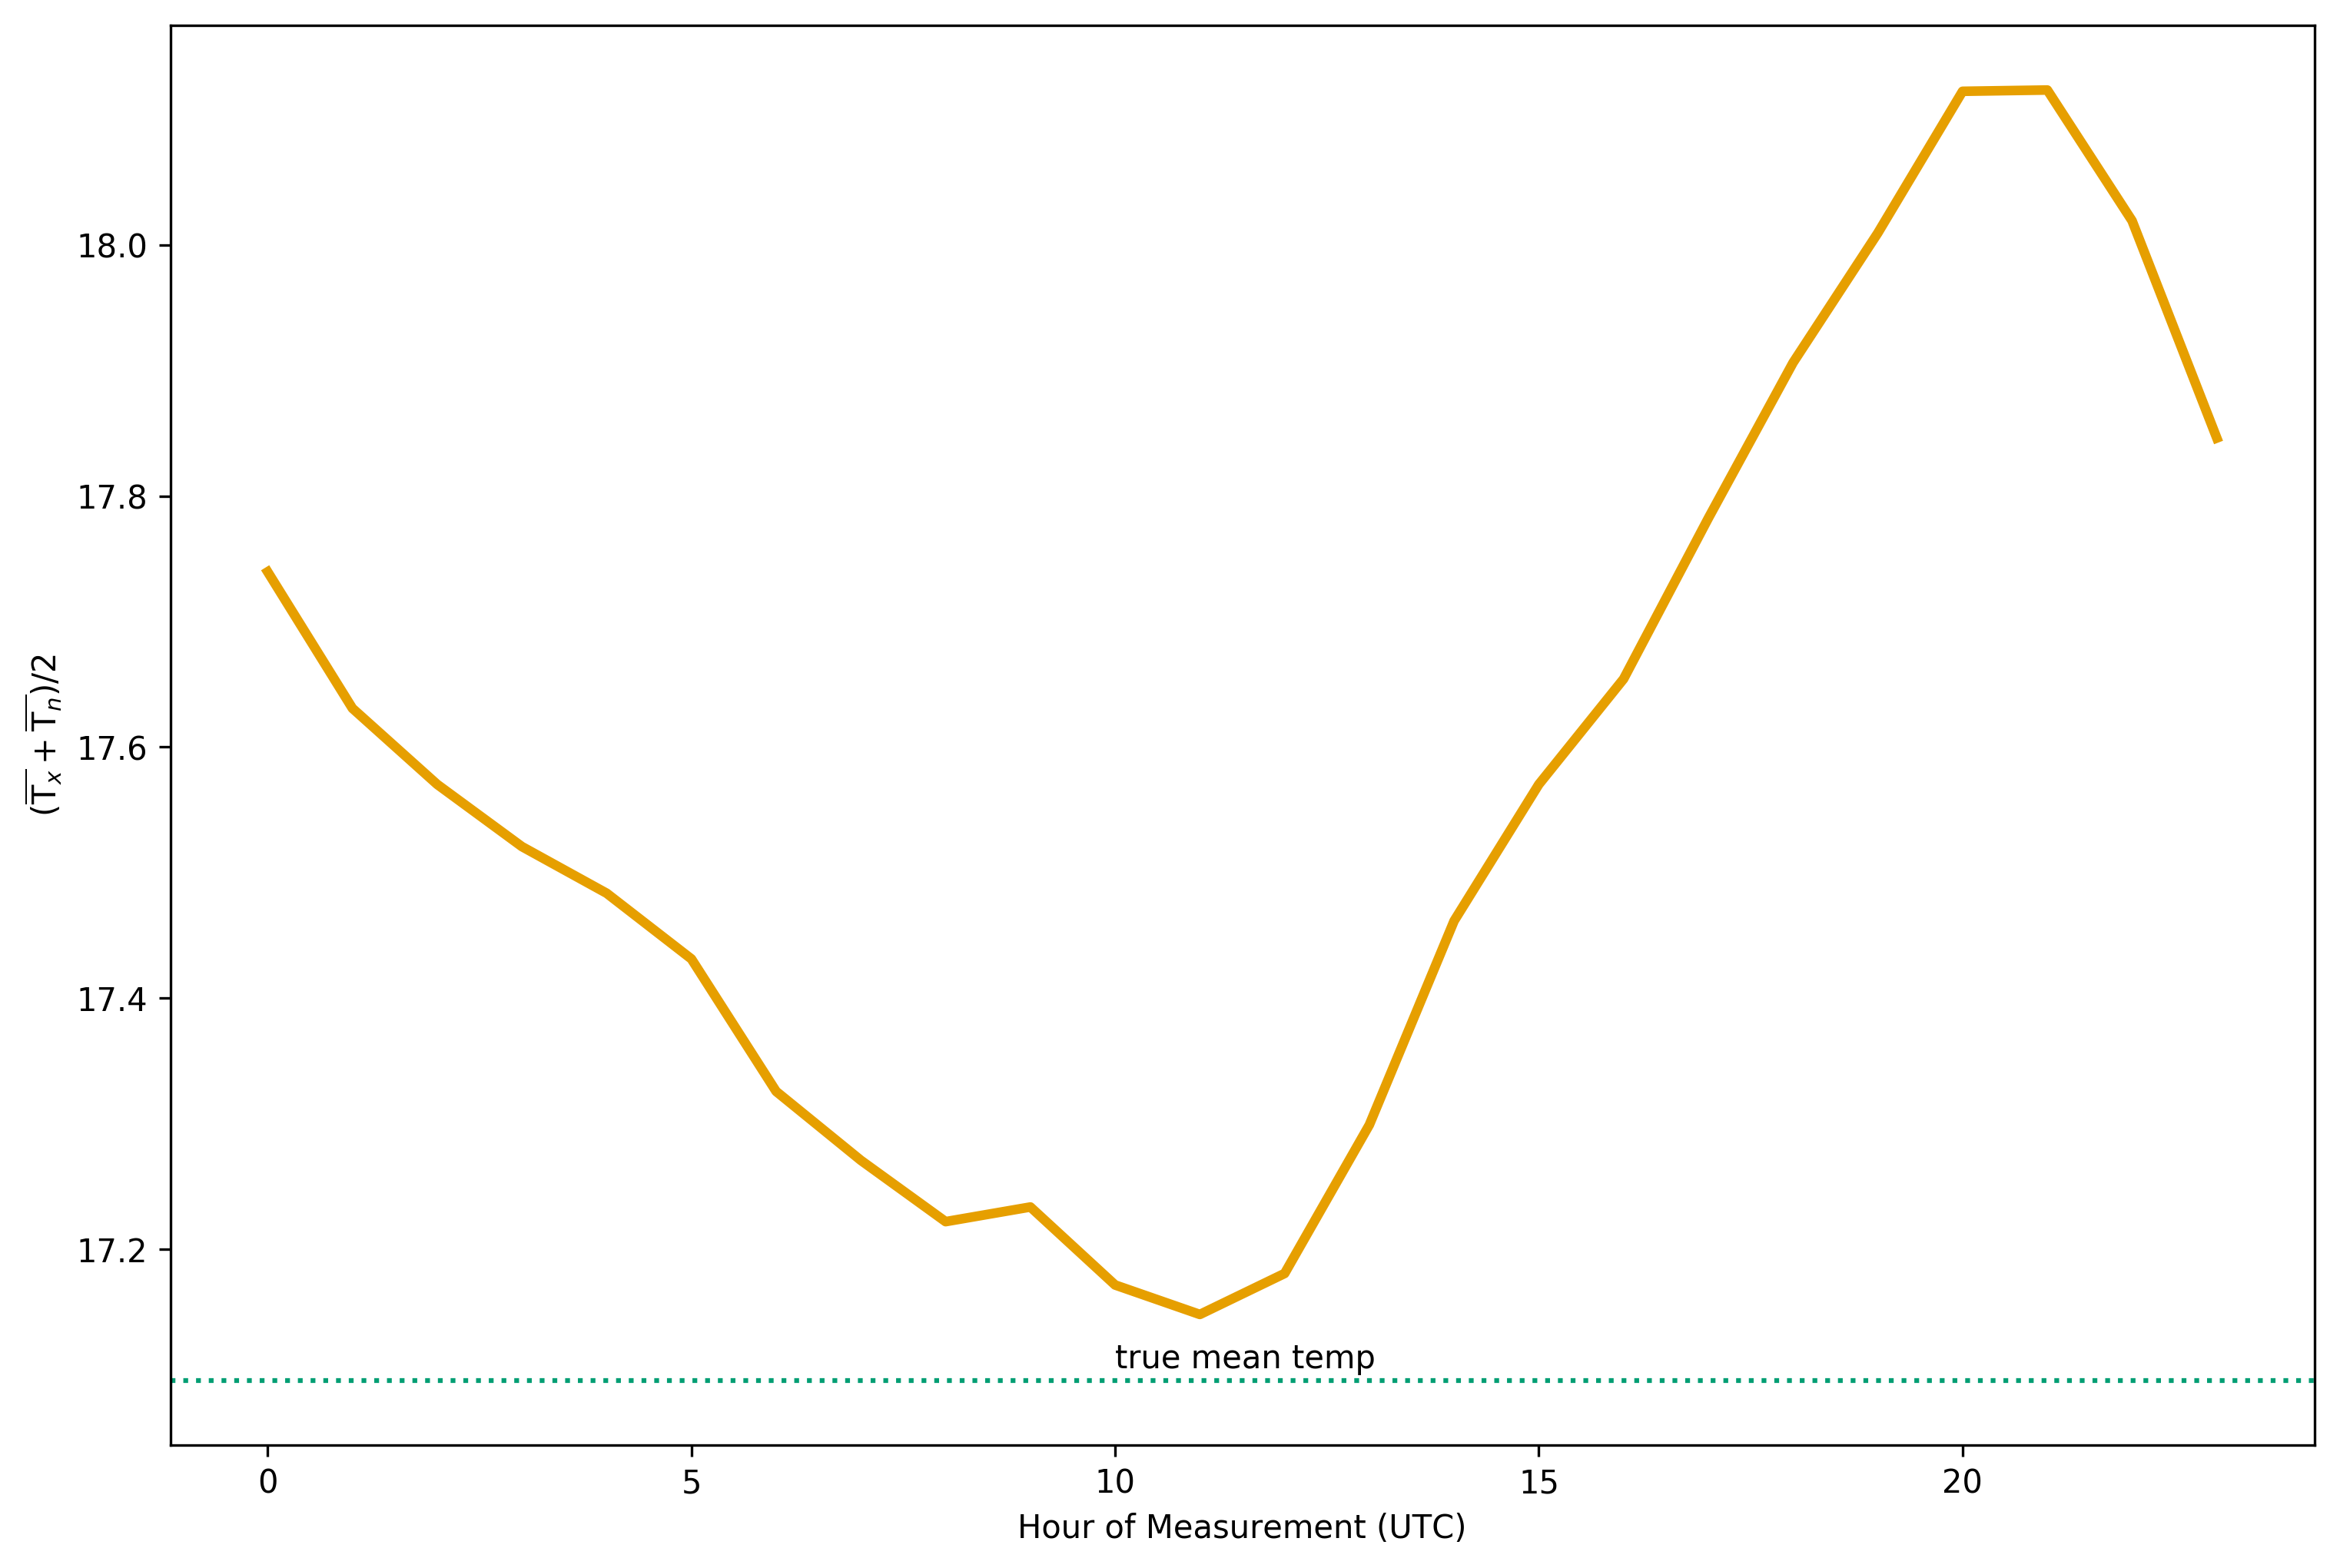

In [8]:
hours = Hour(0):Hour(1):Hour(23)
for (usaf, wban) in usaf_wban
    id = usaf
    station_data = TempModel.read_station(usaf, wban, id; data_dir=data_dir)
    true_mean_temp = InferMean.mean_temp(station_data[:temp], station_data[:ts])
    meanTnTx_by_hr = InferMean.get_mean_TnTx_by_hr(station_data, hours)
    plt.clf()
    InferMean.plot_mean_TnTx(hours, meanTnTx_by_hr, true_mean_temp)
    plt.savefig(@sprintf("../figures/mean_TnTx/%d-%d_mean_temp_by_hour.png", usaf, wban), bbox_inches="tight")
    plt.savefig(@sprintf("../figures/mean_TnTx/%d-%d_mean_temp_by_hour.pdf", usaf, wban), bbox_inches="tight")
end